In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [2]:
# 1. Загрузка данных
df = pd.read_csv('Go Russia.csv')

# 2. Предварительная проверка данных
print("Первые 5 строк:")
print(df.head())
print("\nКолонки датафрейма:")
print(df.columns)
print("\nИнформация о датафрейме:")
df.info()

# 3. Обработка пропущенных значений
df = df.dropna(subset=['Текст'])
df['Текст'] = df['Текст'].astype(str)

# 4. Рассчёт основных параметров
df['char_length'] = df['Текст'].apply(len)  # Длина в символах
df['word_count'] = df['Текст'].apply(lambda x: len(x.split()))  # Количество слов
df['unique_words'] = df['Текст'].apply(lambda x: len(set(x.split())))  # Уникальные слова
df['lexical_diversity'] = df.apply(
    lambda x: x['unique_words'] / x['word_count'] if x['word_count'] > 0 else 0,
    axis=1
)  # Лексическое разнообразие
df['avg_word_length'] = df['Текст'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)  # Средняя длина слова

# 5. Статистика по датафрейму
total_texts = len(df)
avg_char_length = df['char_length'].mean()
avg_word_count = df['word_count'].mean()

print("\n" + "="*50)
print(f"Общее количество текстов: {total_texts}")
print(f"Средняя длина текста в символах: {avg_char_length:.2f}")
print(f"Среднее количество слов в тексте: {avg_word_count:.2f}")
print(f"Среднее количество уникальных слов: {df['unique_words'].mean():.2f}")
print(f"Среднее лексическое разнообразие: {df['lexical_diversity'].mean():.4f}")
print(f"Средняя длина слова: {df['avg_word_length'].mean():.2f} символов")
print("="*50)

Первые 5 строк:
                                           Заголовок  \
0                     Работа на Юге. ТОП-15 Вакансий   
1  Куда дети перевозят своих родителей? Где прове...   
2         Головой на море, "одним местом" на диване.   
3                       Лучший город России. Рейтинг   
4                               Жить у моря полезно.   

                                               Текст  \
0  Строительная сфера на юге развивается семимиль...   
1  Климат морской полезен для всех. Очень часто м...   
2  Если вы в эти дни не на морене расстраивайтесь...   
3  Ты все ещё ищешь лучший город России? Блогер-у...   
4  Я тут наткнулся на статью про воду там ученые ...   

                 Дата публикации                             Эмодзи  \
0  23.07.2023 10:13:35 UTC+04:00  {'👍': 23, '❤': 1, '👏': 1, '😁': 1}   
1  24.07.2023 11:45:50 UTC+04:00                  {'👍': 23, '🐳': 3}   
2  25.07.2023 12:48:20 UTC+04:00          {'👍': 11, '❤': 2, '🤔': 1}   
3  26.07.2023 14:52:33 UTC

In [3]:
!pip install -U spacy
!python -m spacy download ru_core_news_sm


nltk.download('stopwords')
nlp = spacy.load("ru_core_news_sm", disable=["parser", "ner"])
russian_stopwords = stopwords.words('russian')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 68.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#  Функция предобработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление спецсимволов и цифр
    text = re.sub(r'[^а-яё\s]', '', text, flags=re.IGNORECASE)

    # Токенизация и лемматизация с помощью spacy
    doc = nlp(text)
    lemmas = [
        token.lemma_ for token in doc
        if token.text not in russian_stopwords
        and len(token.text) > 2
        and token.is_alpha
    ]

    return ' '.join(lemmas)

#  Предобработка текста
print("\nНачало предобработки текста...")
combined_texts = (df['Заголовок'].fillna('') + ' ' + df['Текст'].fillna(''))
tqdm.pandas(desc="Предобработка текстов")
df['processed_text'] = combined_texts.progress_apply(preprocess_text)
print("Предобработка текста завершена!")

#  Создание эмбеддингов
print("\nСоздание векторных представлений текстов...")
texts = df['processed_text'].tolist()
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)
print(f"Создано {len(embeddings)} векторных представлений размерностью {embeddings.shape[1]}")


Начало предобработки текста...


Предобработка текстов: 100%|██████████| 2849/2849 [01:17<00:00, 36.57it/s]


Предобработка текста завершена!

Создание векторных представлений текстов...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

Создано 2849 векторных представлений размерностью 384


In [5]:
# сравнение текстов
print("\nПример текста до обработки:")
print(combined_texts.iloc[0])
print("\nПример текста после обработки:")
print(df['processed_text'].iloc[0])


Пример текста до обработки:
Работа на Юге. ТОП-15 Вакансий Строительная сфера на юге развивается семимильными шагами. Если вы спец. в какой-либо строительной сфера для вас всегда будет работа архитектура дизайн интерьера ландшафтный дизайн и тд Агенства недвижимости. На Юге комиссию платит не покупатель а продавец. Но не стройте иллюзий если у вас нет опыта вероятнее всего и ну будет продаж. Поэтому нужно постоянно проходить различные обучения в этом направлении и конечно же знать город. Сфера Отелей и Санаториев. Здесь их более соответственно вакансий в этом направлении предостаточно Общепит рестораны кафе барыосновные заработки конечно же летом но если заведение одно из топовых то и местные жители любят частенько походить по заведениям Фриланс. Юг РоссииКраснодар Сочи столицы фрилансеров. Медицинская сфера Сфера образования частные школы и детские сады переполнены Банки и все что с ними связано Спорт. Наследие от олимпиады в Сочи. И конечно же спортивных секций здесь предостаточно. 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import numpy as np


Обработка для 2 кластеров...
Кластеров: 2 | inertia: 14287 | Silhouette avg: 0.069


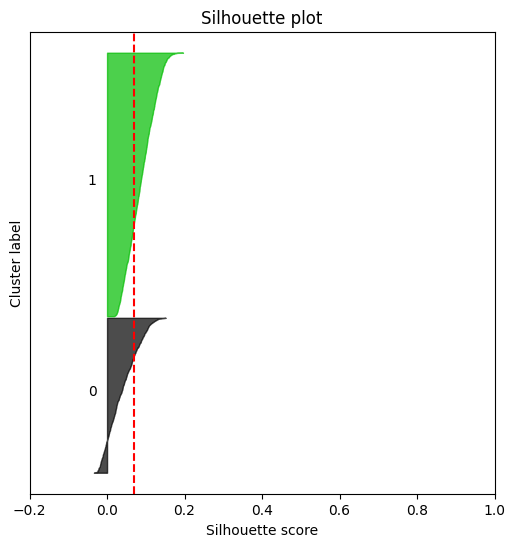


Обработка для 3 кластеров...
Кластеров: 3 | inertia: 13706 | Silhouette avg: 0.049


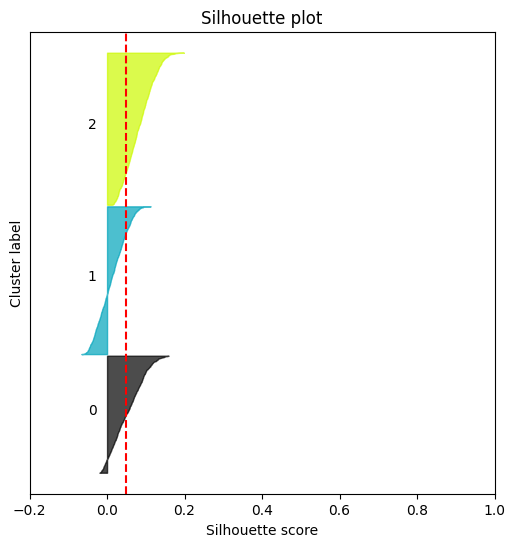


Обработка для 4 кластеров...
Кластеров: 4 | inertia: 13247 | Silhouette avg: 0.047


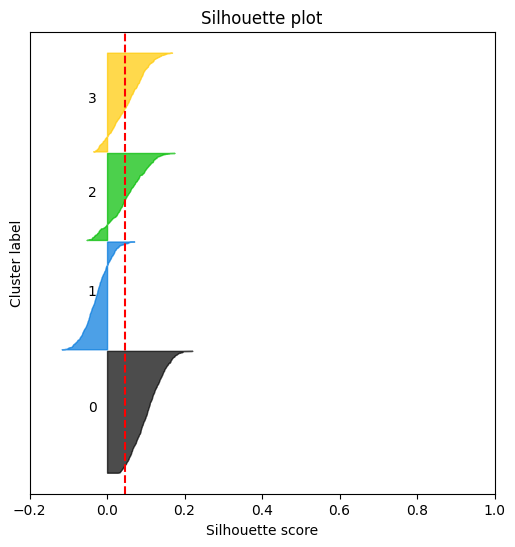


Обработка для 5 кластеров...
Кластеров: 5 | inertia: 12960 | Silhouette avg: 0.051


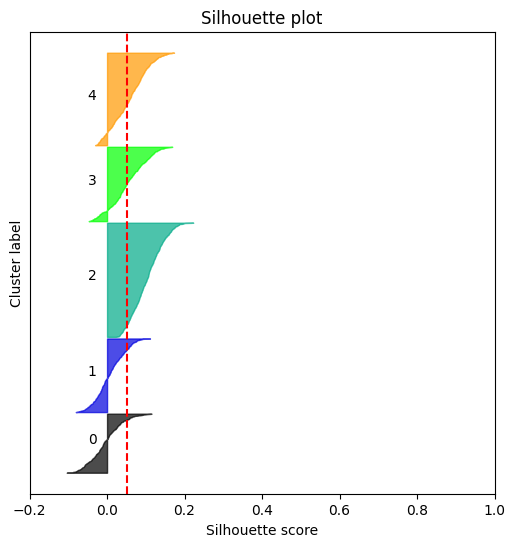


Обработка для 6 кластеров...
Кластеров: 6 | inertia: 12735 | Silhouette avg: 0.049


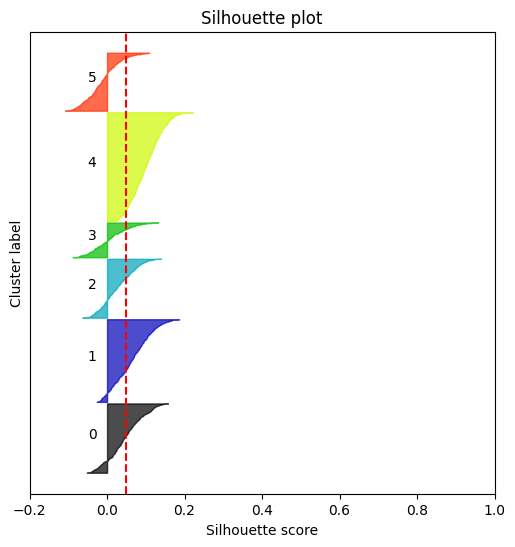


Обработка для 7 кластеров...
Кластеров: 7 | inertia: 12515 | Silhouette avg: 0.042


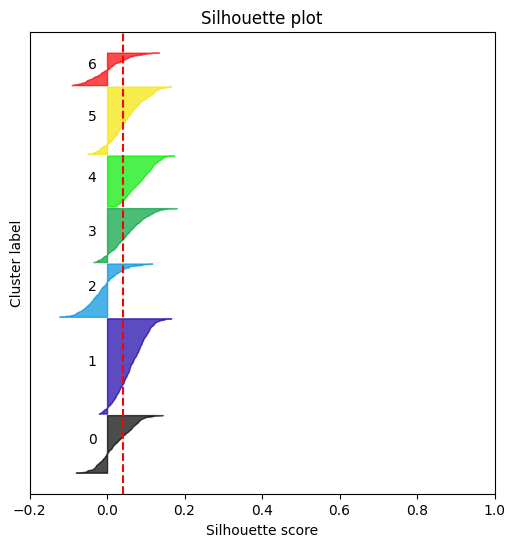

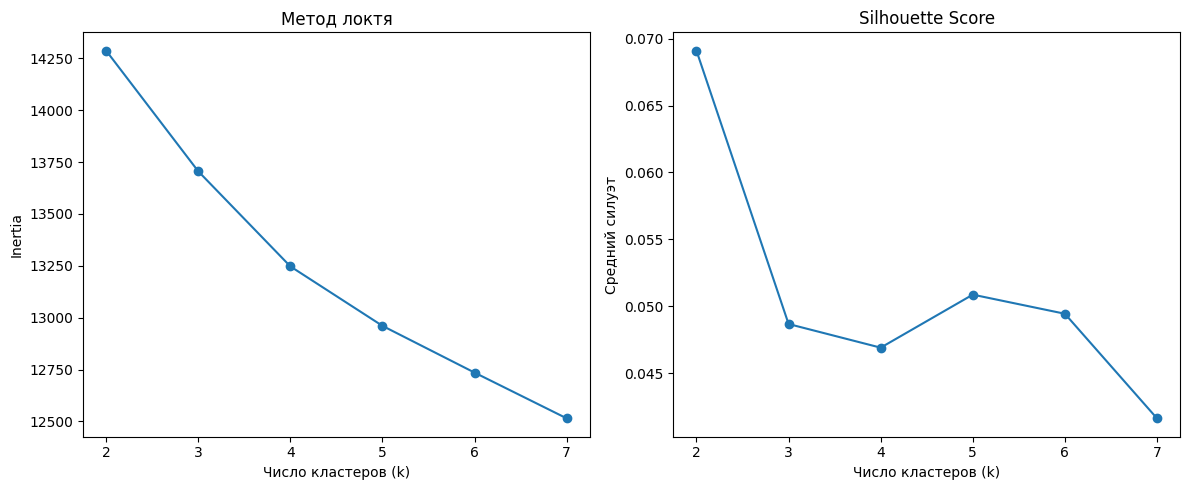


Введите оптимальное число кластеров на основе графиков: 4

Кластеризация с 4 кластерами...
Снижение размерности с помощью t-SNE...


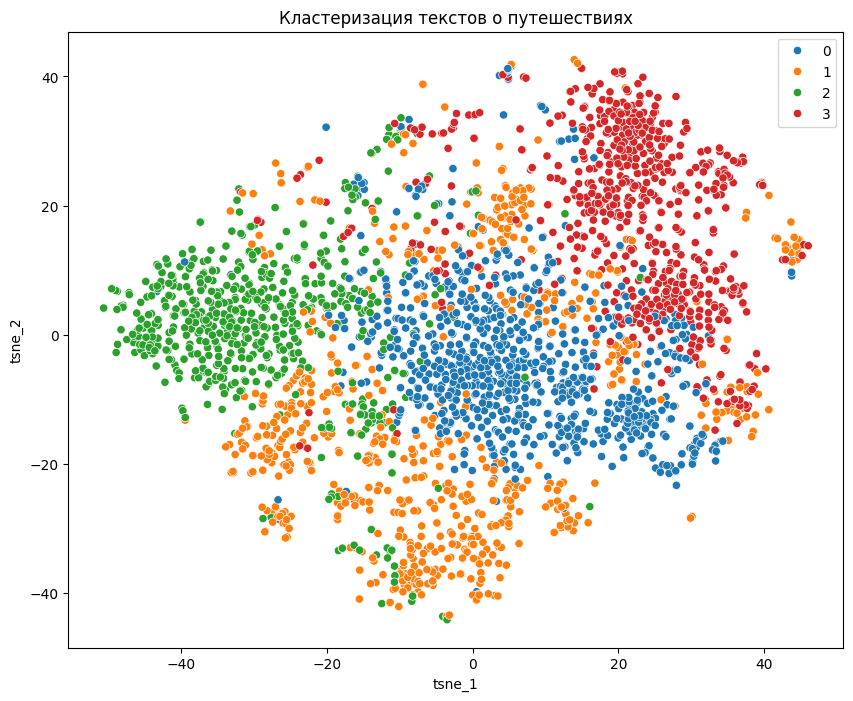

Результаты сохранены в Go_Russia_clusters.csv

Примеры текстов по кластерам:

Cluster 0 (836 текстов):
 1. Маяк Рудный
 2. Доли́на ге́йзеров
 3. Лестница 800 ступеней
 4. Салтинский водопад — единственный в Дагестане подземный водопад🗺️:
 5. Хребет Малые Бамбаки, недалеко от Псебая в Краснодарском крае

Cluster 1 (739 текстов):
 1. Почему люди переезжают в другие города
 2. Краснодарский край стал самым привлекательным регионом для переезда
 3. Как россияне экономят на турах
 4. Развитие туризма в Алтайском крае привлекло в бюджет региона 2 млрд рублей
 5. Строительство трассы М-12 от Москвы до Казани почти завершено.

Cluster 2 (597 текстов):
 1. Работа на Юге. ТОП-15 Вакансий
 2. Лучший город России. Рейтинг
 3. Бранденбургские ворота
 4. Прекрасный Суздаль на закате
 5. Кинодеревня в Ленинских Горках — настоящий портал в прошлое!

Cluster 3 (677 текстов):
 1. Куда дети перевозят своих родителей? Где провести старость в России?
 2. Головой на море, "одним местом" на диване.
 3. Жить 

In [7]:
# ---- ФУНКЦИЯ СИЛУЭТНОГО ГРАФИКА ----
def plot_silhouettes(samples_silhouettes, labels, n_clusters, silhouette_avg):
    fig, ax = plt.subplots(figsize=(6, 6))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = samples_silhouettes[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing between silhouette plots

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette score")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.2, 1.1, 0.2))
    plt.show()

# ---- ПОИСК ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ, СИЛУЭТНЫЕ ГРАФИКИ ----
K = range(2, 8)
inertias = []
silhouette_avgs = []

for k in K:
    print(f"\nОбработка для {k} кластеров...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(embeddings, labels)
    silhouette_avgs.append(silhouette_avg)
    inertias.append(inertia)
    print(f"Кластеров: {k} | inertia: {inertia:.0f} | Silhouette avg: {silhouette_avg:.3f}")

    # Считаем силуэты для всех точек
    samples_silhouettes = silhouette_samples(embeddings, labels)

    # Визуализация силуэтного графика для данного k
    plot_silhouettes(samples_silhouettes, labels, k, silhouette_avg)

# Графики локтя и силуэта
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_avgs, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Средний силуэт')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# ВЫБОР ЧИСЛА КЛАСТЕРОВ по анализу графиков
NUM_CLUSTERS = int(input("\nВведите оптимальное число кластеров на основе графиков: "))

# 4. Кластеризация с выбранным числом кластеров
print(f"\nКластеризация с {NUM_CLUSTERS} кластерами...")
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)
df['cluster'] = clusters

# 5. Визуализация на плоскости
print("Снижение размерности с помощью t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
emb_2d = tsne.fit_transform(embeddings)

df['tsne_1'] = emb_2d[:, 0]
df['tsne_2'] = emb_2d[:, 1]

plt.figure(figsize=(10,8))
sns.scatterplot(x=df['tsne_1'], y=df['tsne_2'], hue=clusters, palette='tab10', legend='full')
plt.title('Кластеризация текстов о путешествиях')
plt.show()

# 6. Сохраняем таблицу
df.to_csv('Go_Russia_clusters.csv', index=False)
print("Результаты сохранены в Go_Russia_clusters.csv")

# 7. Просмотр примеров из каждого кластера
print("\nПримеры текстов по кластерам:")
for i in range(NUM_CLUSTERS):
    cluster_size = len(df[df['cluster'] == i])
    print(f"\nCluster {i} ({cluster_size} текстов):")
    cluster_examples = df[df['cluster'] == i]['Заголовок'].head(5).tolist()
    for j, example in enumerate(cluster_examples, 1):
        print(f' {j}. {example}')

In [8]:
!pip install stop-words
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=1272adf6c2dd874710588cf366d2c98e017850872f8febb3e316f545e9a07752
  Stored in directory: /root/.cache/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop-words



АНАЛИЗ КЛАСТЕРОВ

### Кластер 0 (836 текстов, 29.3% данных):
🔑 Ключевые слова: гора, место, водопад, вид, река, высота, горный, вершина, метр, красивый, скала, дорога, находиться, ущелие, природа

📝 Примеры заголовков:
 1. Маяк Рудный
 2. Доли́на ге́йзеров
 3. Лестница 800 ступеней
 4. Салтинский водопад — единственный в Дагестане подземный водопад🗺️:
 5. Хребет Малые Бамбаки, недалеко от Псебая в Краснодарском крае
 6. Путешествие на родник Красный Ключ, Башкортостан
 7. Малая гора Идолов — Маньпупунёр
 8. Закат в горах Кавказа. Карачаево-Черкесия
 9. Мыс Таранный
 10. Река Сулак, Дагестан
 11. Пинежский заповедник
 12. Прогулка по облакам, Сулакский каньон
 13. Гранитный каньон
 14. Вид на Загеданские озёра с одноимённого перевала
 15. Старинная однокресельная канатная дорога
 16. Кальдера вулкана Заварицкого, на острове Симушир
 17. Что может быть лучше гор? Только горы!
 18. Одно из самых доступных мест в Приэльбрусье для летне-осеннего похода
 19. Перевал Кату-Ярык
 20. Топ мест 

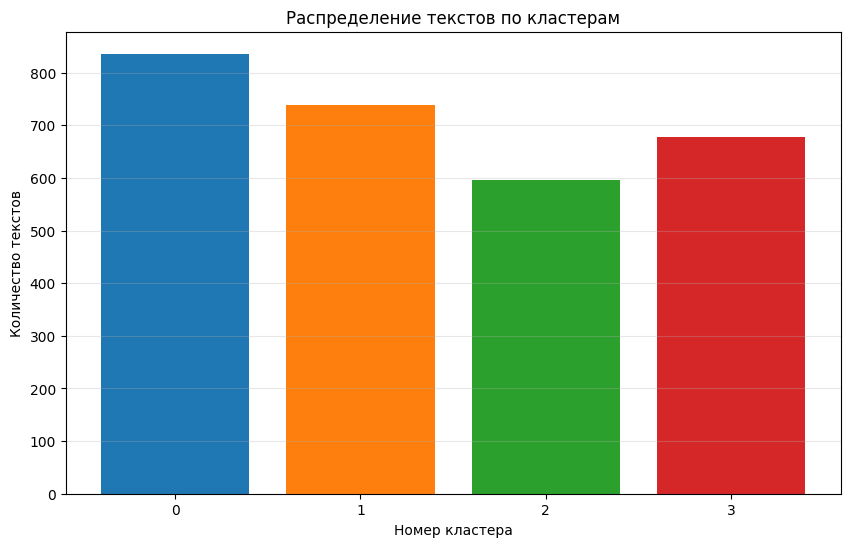


СРЕДНИЕ ХАРАКТЕРИСТИКИ ПО КЛАСТЕРАМ
   Кластер  Символы  Слова  Лекс.разнообр.  Ср.длина слова
0        0   387.35  54.94            0.93            6.10
1        1   351.14  50.81            0.93            5.95
2        2   421.81  58.13            0.92            6.32
3        3   370.03  53.02            0.93            6.02


/tmp/ipython-input-9-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-9-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-9-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-9-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is depre

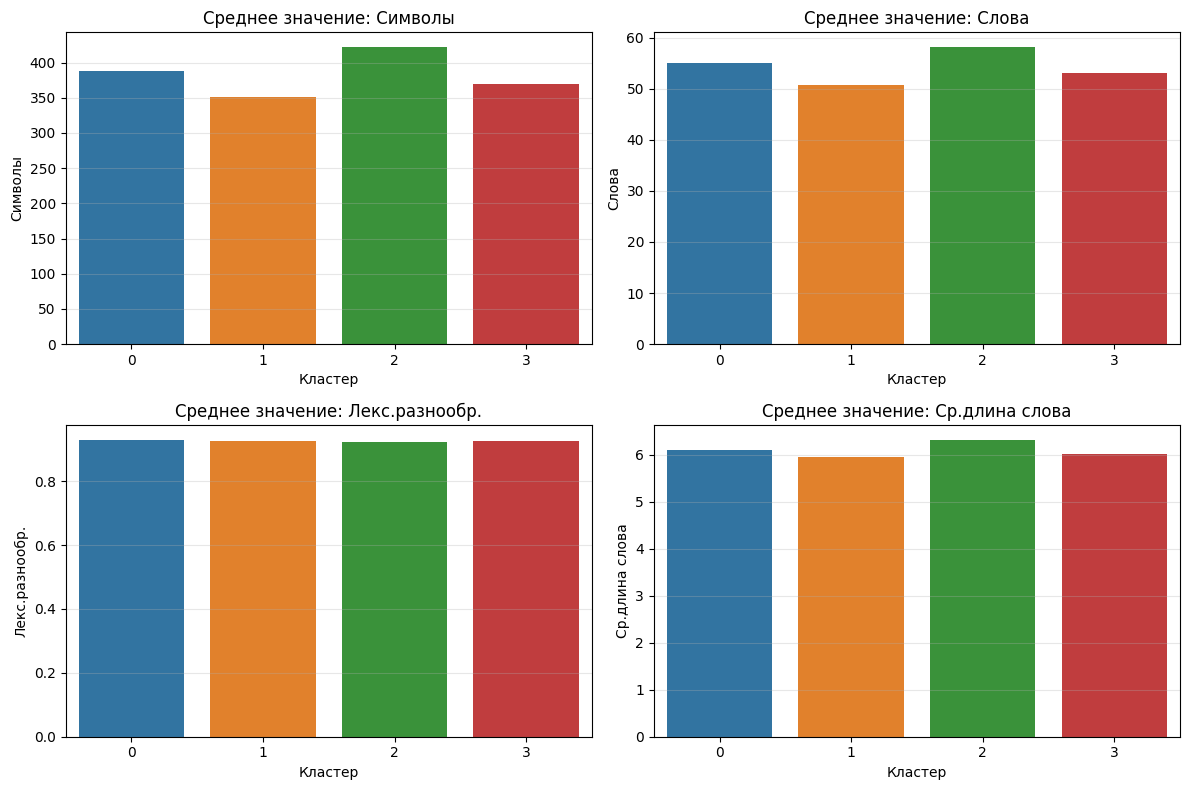

In [9]:
# функция для анализа кластеров
def show_cluster_info(df, text_col='processed_text', title_col='Заголовок', n_top_words=15):
    russian_stop_words = get_stop_words('russian')

    print("\n" + "="*50)
    print("АНАЛИЗ КЛАСТЕРОВ")
    print("="*50)

    cluster_stats = []

    for c in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == c]
        cluster_size = len(cluster_df)
        cluster_stats.append((c, cluster_size))

        print(f"\n### Кластер {c} ({cluster_size} текстов, {cluster_size/total_texts:.1%} данных):")

        # Извлекаем тексты кластера
        cluster_texts = cluster_df[text_col].dropna().astype(str).tolist()

        if not cluster_texts:
            print('Нет текстов для анализа!')
            continue

        # Анализ ключевых слов через TF-IDF
        try:
            vectorizer = TfidfVectorizer(max_features=500, stop_words=russian_stop_words)
            tfidf_matrix = vectorizer.fit_transform(cluster_texts)
            words = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.mean(axis=0).A1
            indices = scores.argsort()[::-1][:n_top_words]
            top_words = [words[i] for i in indices]

            print(f'🔑 Ключевые слова: {", ".join(top_words)}')
        except ValueError:
            print("⚠️ Не удалось извлечь ключевые слова (возможно, недостаточно разнообразная лексика)")

        # Примеры заголовков
        titles = cluster_df[title_col].dropna().astype(str).tolist()[:20]
        print("\n📝 Примеры заголовков:")
        for i, title in enumerate(titles, 1):
            print(f" {i}. {title}")

    # Визуализация распределения кластеров
    plt.figure(figsize=(10, 6))
    clusters, counts = zip(*sorted(cluster_stats, key=lambda x: x[0]))
    plt.bar([str(c) for c in clusters], counts, color=plt.cm.tab10.colors[:len(clusters)])
    plt.title('Распределение текстов по кластерам')
    plt.xlabel('Номер кластера')
    plt.ylabel('Количество текстов')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Вызываем функцию анализа кластеров
show_cluster_info(df)

# Дополнительный анализ: средние характеристики по кластерам
print("\n" + "="*50)
print("СРЕДНИЕ ХАРАКТЕРИСТИКИ ПО КЛАСТЕРАМ")
print("="*50)

cluster_metrics = df.groupby('cluster').agg({
    'char_length': 'mean',
    'word_count': 'mean',
    'lexical_diversity': 'mean',
    'avg_word_length': 'mean'
}).reset_index()

cluster_metrics.columns = ['Кластер', 'Символы', 'Слова', 'Лекс.разнообр.', 'Ср.длина слова']
print(cluster_metrics.round(2))

# Визуализация метрик
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['Символы', 'Слова', 'Лекс.разнообр.', 'Ср.длина слова'], 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
    plt.title(f'Среднее значение: {metric}')
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Введите оптимальное число кластеров на основе графиков: 5

Кластеризация с 5 кластерами...
Снижение размерности с помощью t-SNE...


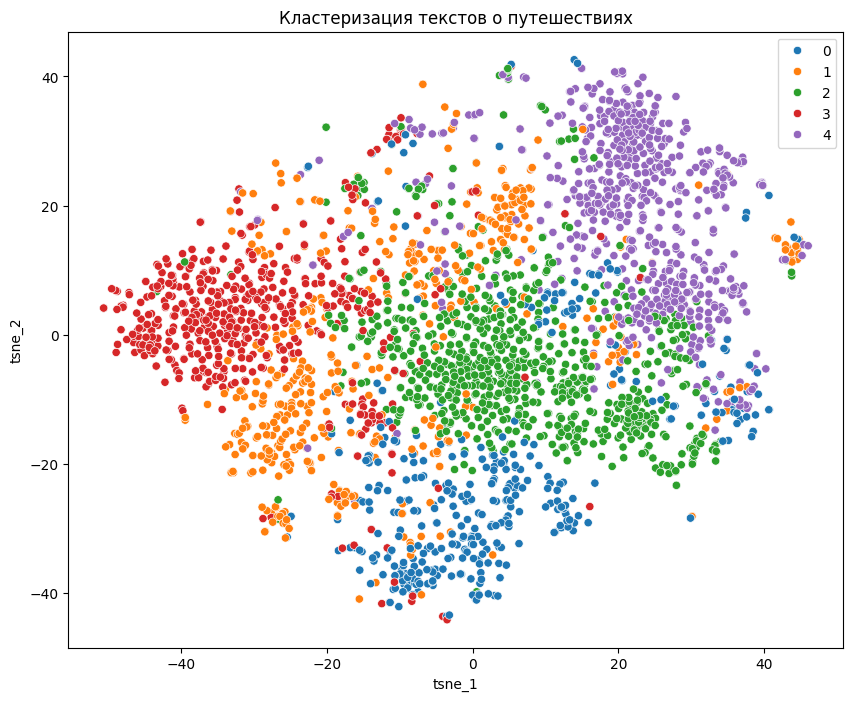

Результаты сохранены в Go_Russia_clusters.csv

Примеры текстов по кластерам:

Cluster 0 (407 текстов):
 1. Как же красиво в Адыгее
 2. Золотой рассвет в Карелии
 3. Рассветы на Усьвинских столбах
 4. Необыкновенная осень на Кольском полуострове
 5. Малиновый закат на Телецком

Cluster 1 (507 текстов):
 1. Работа на Юге. ТОП-15 Вакансий
 2. Куда дети перевозят своих родителей? Где провести старость в России?
 3. Лучший город России. Рейтинг
 4. Почему люди переезжают в другие города
 5. Краснодарский край стал самым привлекательным регионом для переезда

Cluster 2 (786 текстов):
 1. Волшебное место Краснодарского края
 2. Доли́на ге́йзеров
 3. Лестница 800 ступеней
 4. Салтинский водопад — единственный в Дагестане подземный водопад🗺️:
 5. Путешествие на родник Красный Ключ, Башкортостан

Cluster 3 (512 текстов):
 1. Бранденбургские ворота
 2. Прекрасный Суздаль на закате
 3. Кинодеревня в Ленинских Горках — настоящий портал в прошлое!
 4. Церковь Воскресения Христова из Билюково в Плёсе

In [10]:
# ВЫБОР ЧИСЛА КЛАСТЕРОВ по анализу графиков
NUM_CLUSTERS = int(input("\nВведите оптимальное число кластеров на основе графиков: "))

# 4. Кластеризация с выбранным числом кластеров
print(f"\nКластеризация с {NUM_CLUSTERS} кластерами...")
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)
df['cluster'] = clusters

# 5. Визуализация на плоскости
print("Снижение размерности с помощью t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
emb_2d = tsne.fit_transform(embeddings)

df['tsne_1'] = emb_2d[:, 0]
df['tsne_2'] = emb_2d[:, 1]

plt.figure(figsize=(10,8))
sns.scatterplot(x=df['tsne_1'], y=df['tsne_2'], hue=clusters, palette='tab10', legend='full')
plt.title('Кластеризация текстов о путешествиях')
plt.show()

# 6. Сохраняем таблицу
df.to_csv('Go_Russia_clusters.csv', index=False)
print("Результаты сохранены в Go_Russia_clusters.csv")

# 7. Просмотр примеров из каждого кластера
print("\nПримеры текстов по кластерам:")
for i in range(NUM_CLUSTERS):
    cluster_size = len(df[df['cluster'] == i])
    print(f"\nCluster {i} ({cluster_size} текстов):")
    cluster_examples = df[df['cluster'] == i]['Заголовок'].head(5).tolist()
    for j, example in enumerate(cluster_examples, 1):
        print(f' {j}. {example}')


АНАЛИЗ КЛАСТЕРОВ

### Кластер 0 (407 текстов, 14.3% данных):
🔑 Ключевые слова: город, зима, зимний, парк, гора, снег, осень, утро, россия, рассвет, место, вечер, новый, небо, новогодний

📝 Примеры заголовков:
 1. Как же красиво в Адыгее
 2. Золотой рассвет в Карелии
 3. Рассветы на Усьвинских столбах
 4. Необыкновенная осень на Кольском полуострове
 5. Малиновый закат на Телецком
 6. Ловим волну уходящего лета
 7. Как всегда прекрасный закат встречаем на плато Бермамыт!
 8. Незабываемые краски Йошкар-Олы
 9. Суперлуние
 10. Золотая осень в Пермском крае. Скоро
 11. Осень на Алтае
 12. Необычная лавина на рассвете на Ольховой
 13. Хотели бы оказаться в палатке с таким видом?
 14. рассвета на плато Бермамыт
 15. Осенняя сказка Домбая
 16. Невероятное развлечение на вечер в Крыму
 17. Нам кажется, нет на Кавказе более красивой осени, чем в районе Домбая!
 18. Летние цветочные открытки из Домбая, Карачаево-Черкесия
 19. Город Балаклава: живописный, уютный и очень древний
 20. Лесная терап

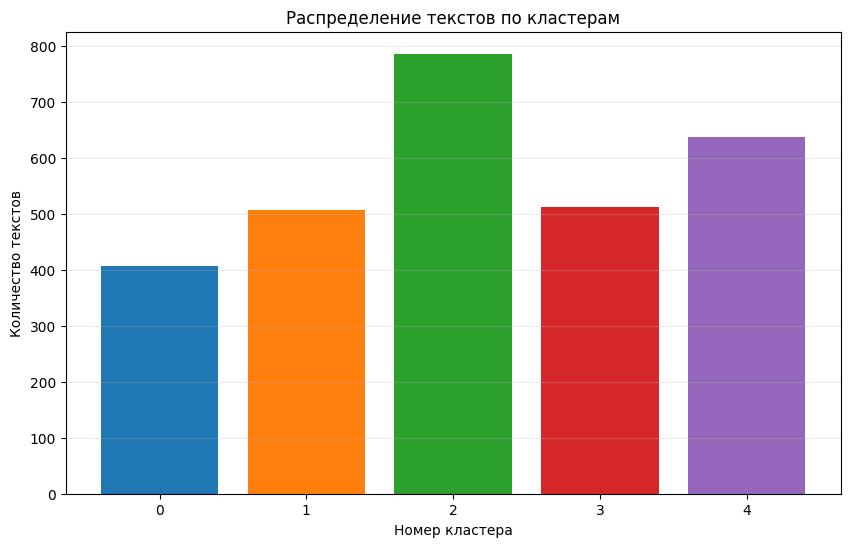


СРЕДНИЕ ХАРАКТЕРИСТИКИ ПО КЛАСТЕРАМ
   Кластер  Символы  Слова  Лекс.разнообр.  Ср.длина слова
0        0   263.46  38.13            0.95            5.95
1        1   459.05  66.08            0.91            5.99
2        2   384.35  54.42            0.93            6.11
3        3   410.80  56.29            0.92            6.35
4        4   366.19  52.52            0.93            6.01


/tmp/ipython-input-10-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-10-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-10-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
/tmp/ipython-input-10-4004531978.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is d

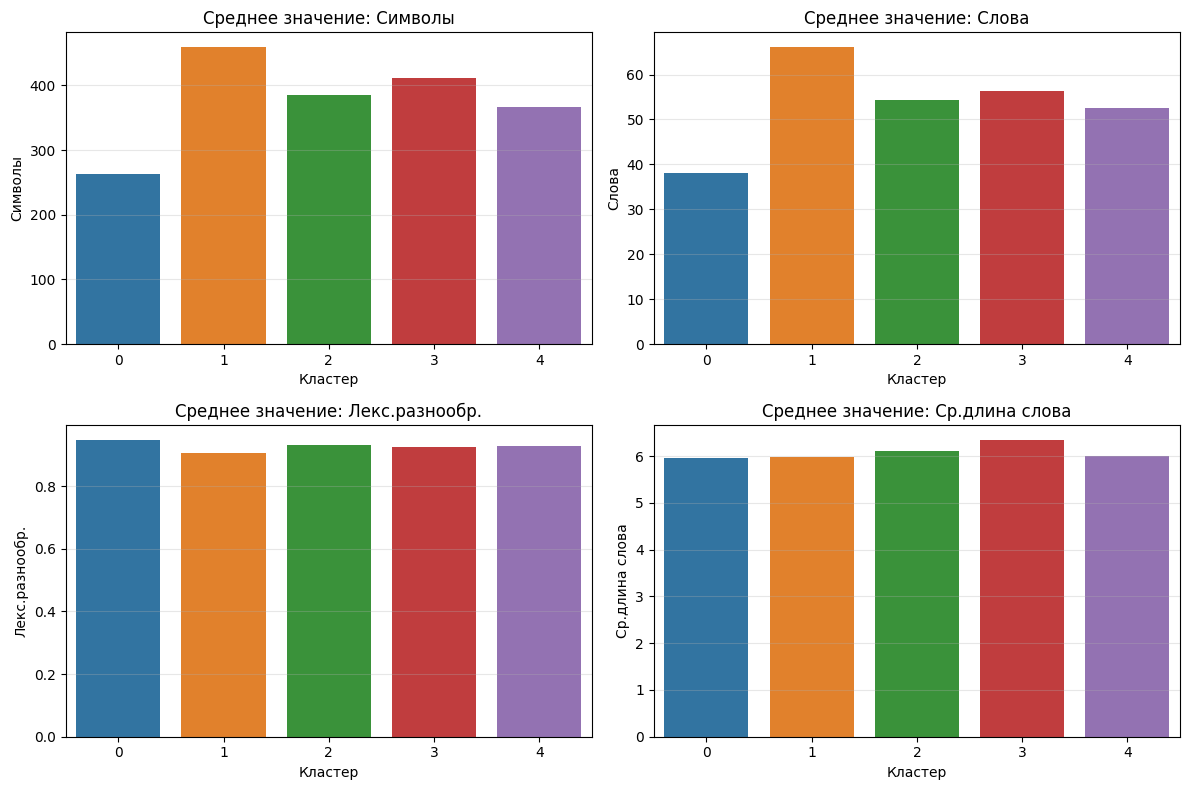

In [ ]:
# функция для анализа кластеров
def show_cluster_info(df, text_col='processed_text', title_col='Заголовок', n_top_words=15):
    russian_stop_words = get_stop_words('russian')

    print("\n" + "="*50)
    print("АНАЛИЗ КЛАСТЕРОВ")
    print("="*50)

    cluster_stats = []

    for c in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == c]
        cluster_size = len(cluster_df)
        cluster_stats.append((c, cluster_size))

        print(f"\n### Кластер {c} ({cluster_size} текстов, {cluster_size/total_texts:.1%} данных):")

        # Извлекаем тексты кластера
        cluster_texts = cluster_df[text_col].dropna().astype(str).tolist()

        if not cluster_texts:
            print('Нет текстов для анализа!')
            continue

        # Анализ ключевых слов через TF-IDF
        try:
            vectorizer = TfidfVectorizer(max_features=500, stop_words=russian_stop_words)
            tfidf_matrix = vectorizer.fit_transform(cluster_texts)
            words = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.mean(axis=0).A1
            indices = scores.argsort()[::-1][:n_top_words]
            top_words = [words[i] for i in indices]

            print(f'🔑 Ключевые слова: {", ".join(top_words)}')
        except ValueError:
            print("⚠️ Не удалось извлечь ключевые слова (возможно, недостаточно разнообразная лексика)")

        # Примеры заголовков
        titles = cluster_df[title_col].dropna().astype(str).tolist()[:20]
        print("\n📝 Примеры заголовков:")
        for i, title in enumerate(titles, 1):
            print(f" {i}. {title}")

    # Визуализация распределения кластеров
    plt.figure(figsize=(10, 6))
    clusters, counts = zip(*sorted(cluster_stats, key=lambda x: x[0]))
    plt.bar([str(c) for c in clusters], counts, color=plt.cm.tab10.colors[:len(clusters)])
    plt.title('Распределение текстов по кластерам')
    plt.xlabel('Номер кластера')
    plt.ylabel('Количество текстов')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Вызываем функцию анализа кластеров
show_cluster_info(df)

# Дополнительный анализ: средние характеристики по кластерам
print("\n" + "="*50)
print("СРЕДНИЕ ХАРАКТЕРИСТИКИ ПО КЛАСТЕРАМ")
print("="*50)

cluster_metrics = df.groupby('cluster').agg({
    'char_length': 'mean',
    'word_count': 'mean',
    'lexical_diversity': 'mean',
    'avg_word_length': 'mean'
}).reset_index()

cluster_metrics.columns = ['Кластер', 'Символы', 'Слова', 'Лекс.разнообр.', 'Ср.длина слова']
print(cluster_metrics.round(2))

# Визуализация метрик
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['Символы', 'Слова', 'Лекс.разнообр.', 'Ср.длина слова'], 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Кластер', y=metric, data=cluster_metrics, palette='tab10')
    plt.title(f'Среднее значение: {metric}')
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()